<a href="https://colab.research.google.com/github/fguidotti-git/FacialRecognition/blob/main/FacialRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Passo 0 — Instalação & imports

In [2]:
!pip -q install mtcnn

import os, glob, random, shutil, io, zipfile
import numpy as np
import cv2
import matplotlib.pyplot as plt
from mtcnn import MTCNN

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image_dataset_from_directory

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Reprodutibilidade
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("TF:", tf.__version__)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 59.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 64.2 MB/s eta 0:00:00
TF: 2.19.0


Passo 1 — (Opcional) Upload do dataset

dataset/
 ├── George/
 ├── John/
 ├── Paul/
 └── Ringo/


In [4]:
import os, zipfile, shutil, glob

ZIP_NAME = "Dataset.zip"
TARGET = "dataset"

# limpa pasta antiga
shutil.rmtree(TARGET, ignore_errors=True)

# extrai o zip para uma pasta temporária
tmp = "_tmp_extract"
shutil.rmtree(tmp, ignore_errors=True)
os.makedirs(tmp, exist_ok=True)

with zipfile.ZipFile(ZIP_NAME, 'r') as z:
    z.extractall(tmp)

# se houver apenas uma pasta raiz dentro do zip, use-a; senão use tmp
entries = [e for e in os.listdir(tmp)]
if len(entries) == 1 and os.path.isdir(os.path.join(tmp, entries[0])):
    root = os.path.join(tmp, entries[0])
else:
    root = tmp

# move/renomeia para "dataset/"
shutil.copytree(root, TARGET, dirs_exist_ok=True)

# limpeza
shutil.rmtree(tmp, ignore_errors=True)

# listar estrutura (1 nível)
print("Conteúdo de 'dataset/':")
for p in sorted([d for d in os.listdir(TARGET) if os.path.isdir(os.path.join(TARGET,d))]):
    n = len(glob.glob(os.path.join(TARGET, p, "*")))
    print(f" - {p}/  ({n} arquivos)")


Conteúdo de 'dataset/':
 - George/  (27 arquivos)
 - John/  (29 arquivos)
 - Paul/  (23 arquivos)
 - Ringo/  (26 arquivos)


Passo 2 — Detecção de faces (MTCNN) → recortes padronizados

In [5]:
detector = MTCNN()
IMG_SIZE = 160
SRC_DIR = "dataset"
DST_DIR = "faces_dataset"
IGNORAR = {"Beatles"}  # ignore fotos de grupo

def detect_boxes(img_bgr, min_size=40):
    rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    res = detector.detect_faces(rgb)
    boxes = []
    for r in res:
        x,y,w,h = r['box']
        if w>=min_size and h>=min_size: boxes.append((max(0,x),max(0,y),w,h))
    return boxes

def crop_with_margin(img_bgr, box, size=IMG_SIZE, margin=0.30):
    x,y,w,h = box
    cx, cy = x + w//2, y + h//2
    m = int(max(w,h)*(1+margin))
    x0=max(cx-m//2,0); y0=max(cy-m//2,0)
    x1=min(cx+m//2, img_bgr.shape[1]); y1=min(cy+m//2, img_bgr.shape[0])
    face = img_bgr[y0:y1, x0:x1]
    if face.size==0: return None
    return cv2.resize(face, (size,size))

# limpar destino
shutil.rmtree(DST_DIR, ignore_errors=True)
os.makedirs(DST_DIR, exist_ok=True)

classes = [d for d in os.listdir(SRC_DIR) if os.path.isdir(os.path.join(SRC_DIR,d)) and d not in IGNORAR]
classes = sorted(classes)
print("Classes:", classes)

per_class_counts = {}
for cls in classes:
    in_dir  = os.path.join(SRC_DIR, cls)
    out_dir = os.path.join(DST_DIR, cls)
    os.makedirs(out_dir, exist_ok=True)
    cnt = 0
    for fp in glob.glob(os.path.join(in_dir, "*")):
        img = cv2.imread(fp)
        if img is None: continue
        # upscale ajuda MTCNN em rostos menores
        img_up = cv2.resize(img, None, fx=2.0, fy=2.0, interpolation=cv2.INTER_CUBIC)
        boxes = detect_boxes(img_up)
        if not boxes: continue
        x,y,w,h = max(boxes, key=lambda b:b[2]*b[3])
        face = crop_with_margin(img_up, (x,y,w,h), margin=0.30)
        if face is None: continue
        cv2.imwrite(os.path.join(out_dir, os.path.basename(fp)), face)
        cnt += 1
    per_class_counts[cls] = cnt

print("Faces recortadas:", per_class_counts)


Classes: ['George', 'John', 'Paul', 'Ringo']
Faces recortadas: {'George': 27, 'John': 28, 'Paul': 23, 'Ringo': 24}


Passo 3 — (Opcional) Aumentar dados até ~100 por classe

In [17]:
SRC = "faces_dataset"
AUG = "faces_dataset_aug"
TARGET = 100

def augment(img):
    # flip
    if random.random()<0.5: img = cv2.flip(img,1)
    # rotação leve
    ang = random.uniform(-8,8)
    h,w = img.shape[:2]
    M = cv2.getRotationMatrix2D((w//2,h//2), ang, 1.0)
    img = cv2.warpAffine(img, M, (w,h), borderMode=cv2.BORDER_REFLECT_101)
    # brilho/contraste
    alpha = random.uniform(0.85,1.15); beta = random.uniform(-15,15)
    img = cv2.convertScaleAbs(img, alpha=alpha, beta=beta)
    # blur leve
    if random.random()<0.25: img = cv2.GaussianBlur(img,(random.choice([3,5]),)*2,0)
    return img

shutil.rmtree(AUG, ignore_errors=True)
os.makedirs(AUG, exist_ok=True)
classes = sorted([d for d in os.listdir(SRC) if os.path.isdir(os.path.join(SRC,d))])

for cls in classes:
    src_cls = os.path.join(SRC, cls)
    dst_cls = os.path.join(AUG, cls)
    os.makedirs(dst_cls, exist_ok=True)
    files = glob.glob(os.path.join(src_cls, "*"))
    # copia originais
    for fp in files:
        im = cv2.imread(fp);
        if im is None: continue
        cv2.imwrite(os.path.join(dst_cls, os.path.basename(fp)), im)
    # gera até TARGET
    i=0
    while len(glob.glob(os.path.join(dst_cls,"*"))) < TARGET and files:
        im = cv2.imread(random.choice(files))
        if im is None: continue
        cv2.imwrite(os.path.join(dst_cls, f"aug_{i:05d}.jpg"), augment(im))
        i+=1

for cls in classes:
    print(cls, "→", len(glob.glob(os.path.join(AUG, cls, "*"))), "imagens")


George → 100 imagens
John → 100 imagens
Paul → 100 imagens
Ringo → 100 imagens


Passo 4 — Split estratificado (train/val)

In [18]:
SRC = "faces_dataset_aug"  # ou "faces_dataset" se pulou o Passo 3
TRAIN_DIR = "train_faces"
VAL_DIR   = "val_faces"
VAL_MIN   = 12
VAL_RATIO = 0.2

shutil.rmtree(TRAIN_DIR, ignore_errors=True)
shutil.rmtree(VAL_DIR,   ignore_errors=True)
os.makedirs(TRAIN_DIR, exist_ok=True)
os.makedirs(VAL_DIR,   exist_ok=True)

classes = sorted([d for d in os.listdir(SRC) if os.path.isdir(os.path.join(SRC,d))])
for cls in classes:
    files = sorted(glob.glob(os.path.join(SRC, cls, "*")))
    random.shuffle(files)
    n=len(files); v = max(VAL_MIN, int(round(n*VAL_RATIO))); v=min(v, n-1)
    val, tr = files[:v], files[v:]
    os.makedirs(os.path.join(TRAIN_DIR, cls), exist_ok=True)
    os.makedirs(os.path.join(VAL_DIR,   cls), exist_ok=True)
    for fp in tr: shutil.copy(fp, os.path.join(TRAIN_DIR, cls, os.path.basename(fp)))
    for fp in val: shutil.copy(fp, os.path.join(VAL_DIR,   cls, os.path.basename(fp)))
    print(f"{cls}: train={len(tr)} | val={len(val)}")


George: train=80 | val=20
John: train=80 | val=20
Paul: train=80 | val=20
Ringo: train=80 | val=20


Passo 5 — Datasets Keras + Extrator de Embeddings

In [19]:
IMG_SHAPE = (160,160)
BATCH=32

train_ds = image_dataset_from_directory(TRAIN_DIR, image_size=IMG_SHAPE, batch_size=BATCH, shuffle=True, seed=SEED)
val_ds   = image_dataset_from_directory(VAL_DIR,   image_size=IMG_SHAPE, batch_size=BATCH, shuffle=False)
class_names = train_ds.class_names
print("Classes:", class_names)

# Feature extractor (ImageNet, sem topo)
backbone = MobileNetV2(input_shape=IMG_SHAPE+(3,), include_top=False, weights="imagenet")
gap = GlobalAveragePooling2D()
feature_extractor = tf.keras.Sequential([tf.keras.Input(shape=IMG_SHAPE+(3,)), backbone, gap])
backbone.trainable = False

def ds_to_embeddings(ds):
    X,Y=[],[]
    for x,y in ds:
        x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
        X.append(feature_extractor(x, training=False).numpy())
        Y.append(y.numpy())
    return np.vstack(X), np.concatenate(Y)

X_tr, y_tr = ds_to_embeddings(train_ds)
X_va, y_va = ds_to_embeddings(val_ds)
print("Embeddings:", X_tr.shape, y_tr.shape, "|", X_va.shape, y_va.shape)


Found 320 files belonging to 4 classes.
Found 80 files belonging to 4 classes.
Classes: ['George', 'John', 'Paul', 'Ringo']
Embeddings: (320, 1280) (320,) | (80, 1280) (80,)


Passo 6 — Classificador SVM (busca curta de hiperparâmetros)

Best SVM: SVC(C=5, class_weight='balanced', probability=True, random_state=42)
Val acc: 0.975
              precision    recall  f1-score   support

      George       0.95      1.00      0.98        20
        John       1.00      0.95      0.97        20
        Paul       1.00      0.95      0.97        20
       Ringo       0.95      1.00      0.98        20

    accuracy                           0.97        80
   macro avg       0.98      0.97      0.97        80
weighted avg       0.98      0.97      0.97        80



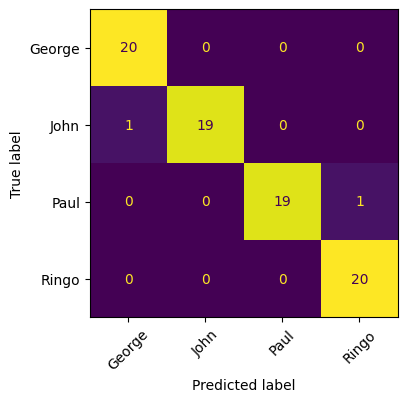

In [20]:
params = {"C":[5,10,20], "gamma":["scale",0.05,0.02], "kernel":["rbf"]}
svm_gs = GridSearchCV(SVC(probability=True, class_weight="balanced", random_state=SEED),
                      params, cv=5, n_jobs=-1)
svm_gs.fit(X_tr, y_tr)
svm = svm_gs.best_estimator_
print("Best SVM:", svm)

pred = svm.predict(X_va)
acc  = accuracy_score(y_va, pred)
print("Val acc:", acc)
print(classification_report(y_va, pred, target_names=class_names))

cm = confusion_matrix(y_va, pred, labels=list(range(len(class_names))))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(4,4)); disp.plot(ax=ax, colorbar=False); plt.xticks(rotation=45); plt.show()


Passo 7 — Inferência completa (detecção → embedding → SVM)

Saving download3.jpeg to download3 (2).jpeg


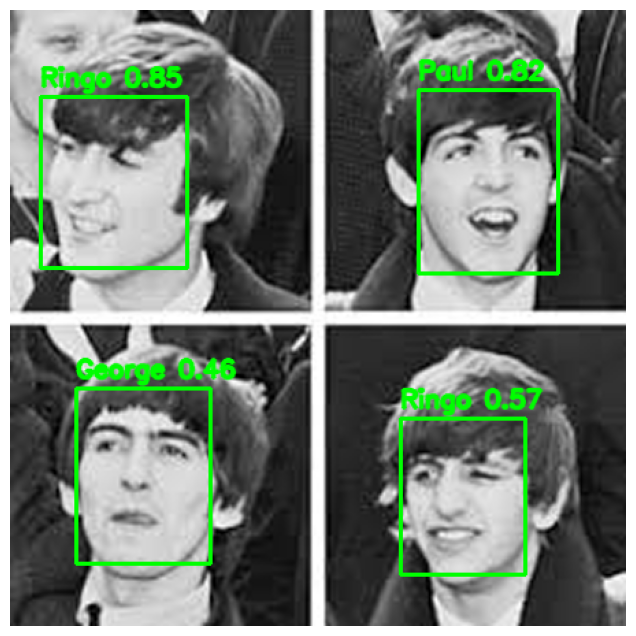

[{'bbox': (285, 298, 91, 114), 'label': 'Ringo', 'score': 0.5688443517829523},
 {'bbox': (48, 276, 98, 128), 'label': 'George', 'score': 0.4562914771260605},
 {'bbox': (298, 58, 102, 134), 'label': 'Paul', 'score': 0.8180877176324994},
 {'bbox': (22, 63, 107, 125), 'label': 'Ringo', 'score': 0.8497629331428196}]

In [28]:
detector = MTCNN()

def predict_faces(img_bgr, threshold=0.30, scale=2.0):
    # upscale ajuda na detecção
    big = cv2.resize(img_bgr, None, fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
    rgb = cv2.cvtColor(big, cv2.COLOR_BGR2RGB)
    dets = detector.detect_faces(rgb)
    annotated = rgb.copy()
    outs = []

    for d in dets:
        x,y,w,h = d['box']; x=max(0,x); y=max(0,y)
        face = crop_with_margin(big, (x,y,w,h), margin=0.30)
        if face is None: continue
        # embedding
        x_in = tf.expand_dims(cv2.cvtColor(face, cv2.COLOR_BGR2RGB).astype(np.float32), 0)
        x_in = tf.keras.applications.mobilenet_v2.preprocess_input(x_in)
        emb  = feature_extractor(x_in, training=False).numpy()
        # SVM
        prob = svm.predict_proba(emb)[0]
        cls  = int(np.argmax(prob)); score = float(prob[cls])
        label = class_names[cls] if score>=threshold else "desconhecido"

        cv2.rectangle(annotated,(x,y),(x+w,y+h),(0,255,0),2)
        cv2.putText(annotated,f"{label} {score:.2f}",(x,y-8),
                    cv2.FONT_HERSHEY_SIMPLEX,0.6,(0,255,0),2,cv2.LINE_AA)

        outs.append({"bbox":(x,y,w,h),"label":label,"score":score})
    return annotated, outs

# Teste:
from google.colab import files
up = files.upload()
img = cv2.imread(list(up.keys())[0])
vis, out = predict_faces(img, threshold=0.30, scale=2.0)
plt.figure(figsize=(10,8)); plt.imshow(vis); plt.axis("off"); plt.show()
out


Passo 8 — Exportar modelo (carregar depois sem re-treinar)

In [12]:
import joblib, os

os.makedirs("export", exist_ok=True)
# backbone+gap é usado só para extrair embeddings; salvamos pesos do backbone
feature_extractor.save("export/feature_extractor_mnetv2.keras")
joblib.dump({"svm": svm, "class_names": class_names}, "export/svm_classifier.joblib")

print("Salvo em export/:")
!ls -lh export


Salvo em export/:
total 12M
-rw-r--r-- 1 root root 9.2M Sep 17 13:32 feature_extractor_mnetv2.keras
-rw-r--r-- 1 root root 2.3M Sep 17 13:32 svm_classifier.joblib
